In [1]:
! nvidia-smi

Wed Apr 23 20:32:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:25:00.0 Off |                    0 |
| N/A   28C    P0             37W /  250W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import gymnasium as gym
import ale_py

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.dqn.policies import CnnPolicy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.atari_wrappers import ClipRewardEnv, EpisodicLifeEnv, MaxAndSkipEnv, FireResetEnv

import os
import re
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

In [3]:
ENV_ID = "ALE/DemonAttack-v5"
LOG_DIR = "./logs/dqn_demonattack/"
FINAL_MODEL_PATH = os.path.join(LOG_DIR, "final_dqn_model.zip")
CHECKPOINT_PREFIX = "dqn_model"
TOTAL_TIMESTEPS = 500000  # Total trained steps: 1M

os.makedirs(LOG_DIR, exist_ok=True)

In [4]:
gym.register_envs(ale_py)

def make_env():
    env = gym.make(ENV_ID, render_mode="rgb_array")
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    env = ClipRewardEnv(env)
    env = Monitor(env)
    return env

env = DummyVecEnv([make_env])
env = VecTransposeImage(env)
env = VecFrameStack(env, n_stack=2)

eval_env = DummyVecEnv([make_env])
eval_env = VecTransposeImage(eval_env)
eval_env = VecFrameStack(eval_env, n_stack=2)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=LOG_DIR,
    log_path=LOG_DIR,
    eval_freq=10000,
    n_eval_episodes=5,
    deterministic=True,
    render=False
)

checkpoint_callback = CheckpointCallback(
    save_freq=50000,
    save_path=LOG_DIR,
    name_prefix=CHECKPOINT_PREFIX
)

def find_latest_checkpoint(log_dir, prefix):
    checkpoint_files = [
        f for f in os.listdir(log_dir)
        if f.startswith(prefix) and f.endswith(".zip")
    ]
    if not checkpoint_files:
        return None

    checkpoint_files.sort(
        key=lambda x: int(re.findall(rf"{prefix}_(\d+)_steps", x)[0]),
        reverse=True
    )
    return os.path.join(log_dir, checkpoint_files[0])

checkpoint_path = find_latest_checkpoint(LOG_DIR, CHECKPOINT_PREFIX)
model = None

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


In [ ]:
if checkpoint_path:
    print(f"Restore checkpoint: {checkpoint_path}")
    model = DQN.load(checkpoint_path, env=env)
elif os.path.exists(FINAL_MODEL_PATH):
    print("Restore final model: final_dqn_model.zip")
    model = DQN.load(FINAL_MODEL_PATH, env=env)
else:
    print("No model detected, start training: ")
    model = DQN(
        CnnPolicy,
        env,
        verbose=1,
        learning_rate=1e-4,
        buffer_size=10000,
        learning_starts=1000,
        batch_size=8,
        tau=1.0,
        gamma=0.99,
        train_freq=8,
        target_update_interval=1000,
        exploration_fraction=0.1,
        exploration_final_eps=0.01,
        exploration_initial_eps=1.0,
        tensorboard_log=LOG_DIR
    )

model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=[eval_callback, checkpoint_callback]
)

model.save(FINAL_MODEL_PATH)

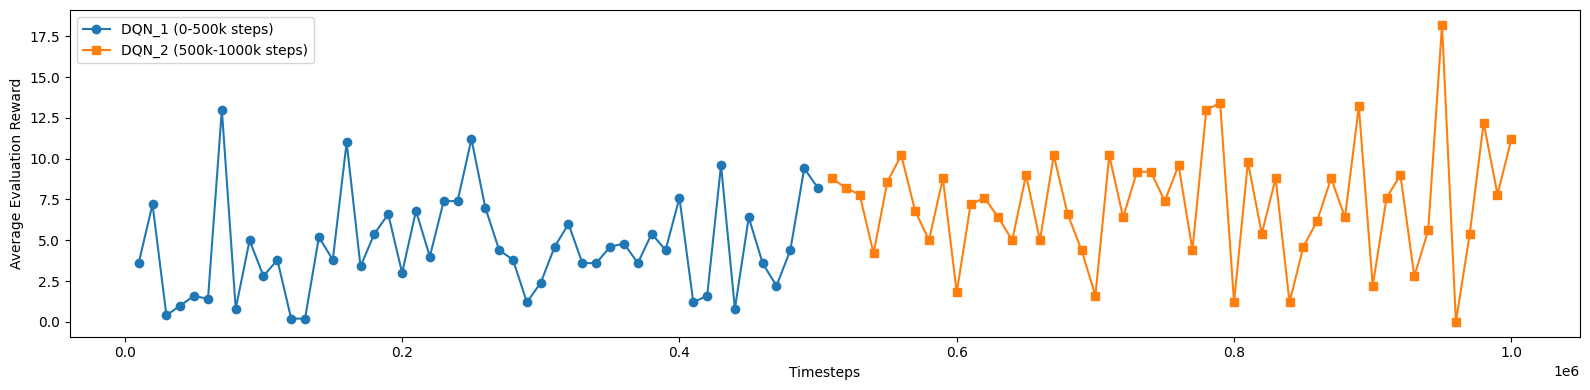

In [6]:
def extract_rewards(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.startswith("events.out.tfevents")]
    ea = event_accumulator.EventAccumulator(event_files[0])
    ea.Reload()
    scalar_data = ea.Scalars('eval/mean_reward')

    timesteps, rewards = [], []
    for entry in scalar_data:
        timesteps.append(entry.step)
        rewards.append(entry.value)
    
    return timesteps, rewards

timesteps1, rewards1 = extract_rewards("./logs/dqn_demonattack/DQN_1/")
timesteps2, rewards2 = extract_rewards("./logs/dqn_demonattack/DQN_2/")

plt.figure(figsize=(16, 4))
plt.plot(timesteps1, rewards1, label="DQN_1 (0-500k steps)", marker="o")
plt.plot([t + timesteps1[-1] for t in timesteps2], rewards2, label="DQN_2 (500k-1000k steps)", marker="s")

plt.xlabel("Timesteps")
plt.ylabel("Average Evaluation Reward")
plt.legend()

plt.tight_layout()
plt.show()